# Overview
In this notebook, I will analyze patterns with avocada prices. Data analysis was performed on different variables that might associate with avocado prices. Different types of predictive models were built. The dataset comes from [Kaggle](https://www.kaggle.com/neuromusic/avocado-prices).

## 1. Data Processing and Feature Engineering

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("avocado.csv",parse_dates=True)

In [3]:
data = data.drop('Unnamed: 0',axis=1)
data.loc[:,"ind"] = data.index+1 #index for linear regression when considering time trend

In [4]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,ind
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,1
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,2
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,3
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,4
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,5


In [5]:
data.loc[:,"Date"] = pd.to_datetime(data["Date"])

In [6]:
#no missing values present
data.isnull().mean().sum()

0.0

<AxesSubplot:xlabel='Date', ylabel='AveragePrice'>

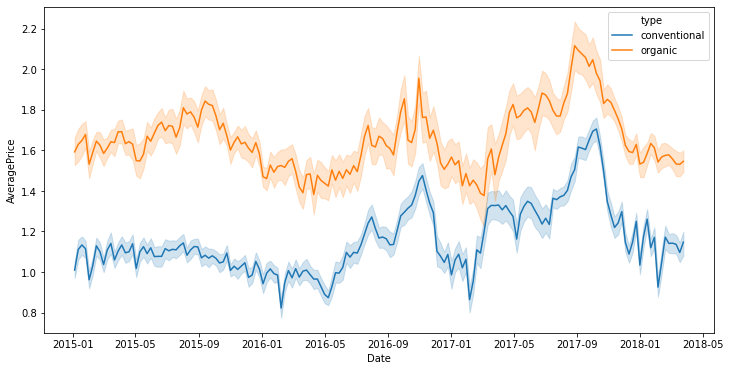

In [7]:
#visualize average prices by type
plt.figure(figsize=(12,6))
sns.lineplot("Date","AveragePrice",hue="type", data=data)

Since the dataset contains a time component, it might be interesting to explore date component, such as day of the week, week of the year, month of the year and quarter. We can use the date time functions to extract those features. One thing to note is that there are multiple data points per day since there are multiple regions with different granularity. We will take this into account in the next section.

In [8]:
data.loc[:,"month"] = data["Date"].dt.month.astype(str)
data.loc[:,"week"] = data["Date"].dt.isocalendar().week.astype(str)
data.loc[:,"quarter"] = data["Date"].dt.quarter.astype(str)

In [9]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,ind,month,week,quarter
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,1,12,52,4
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,2,12,51,4
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,3,12,50,4
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,4,12,49,4
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,5,11,48,4


## EDA
- Overall distribution of prices
- Number sold in each of the PLU type
- Number of different bag sizes
- Differences in prices across regions
- Weekly, monthly, quarterly patterns

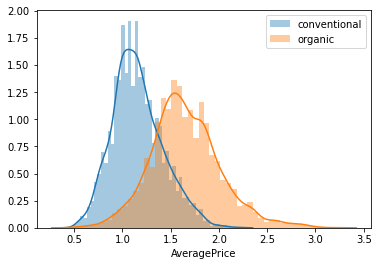

In [10]:
sns.distplot(data[data["type"]=="conventional"]["AveragePrice"],label = "conventional") #roughly normal for both types
sns.distplot(data[data["type"]=="organic"]["AveragePrice"],label="organic")
plt.legend()

In [11]:
data.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'ind', 'month', 'week', 'quarter'],
      dtype='object')

In [12]:
df = data[['Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'month', 'week', 'quarter']]

In [13]:
#by type
by_type = df.groupby("type").sum().reset_index()
by_type 

,type,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
0,conventional,1.508722e+10,5.280410e+09,5.245673e+09,4.143733e+08,4.146764e+09,3.164183e+09,9.259030e+08,56678255.60,18399366
1,organic,4.361817e+08,6.670082e+07,1.406024e+08,2.429041e+06,2.264115e+08,1.606877e+08,6.571281e+07,10921.73,18393317


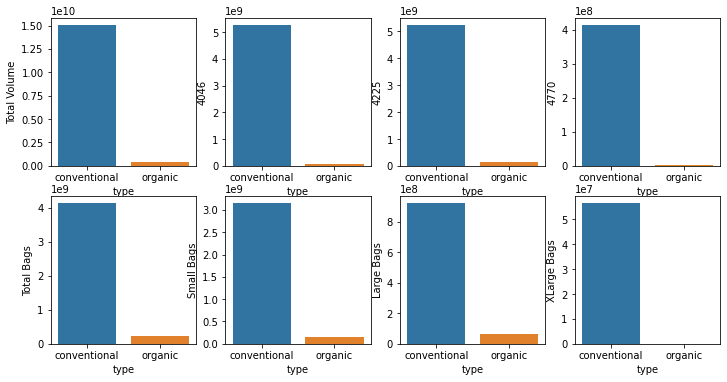

In [14]:
fig,ax=plt.subplots(nrows = 2,ncols=4,figsize=(12,6))
c = 0
r=0
for i in np.arange(1,9):
    if c<3:
        sns.barplot(by_type["type"],by_type[by_type.columns[i]], ax = ax[r][c])
        c+=1
    else:
        if r == 0:
            sns.barplot(by_type["type"],by_type[by_type.columns[i]], ax = ax[r][c])
            r = 1
            c=0
        elif r==1:
            sns.barplot(by_type["type"],by_type[by_type.columns[i]], ax = ax[r][c])
        
    

There are a lot more volumes for conventional type than organic, for organic, there seemed to be more large bagas than small bags, almost no X-large bags. There are more 4225 PLU avocado among organic products.

In [15]:
#by region, different granularity
by_region = df.groupby("region").sum().reset_index()
by_region

,region,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
0,Albany,1.606780e+07,6.165396e+05,1.271597e+07,5.503733e+04,2.680255e+06,2.246945e+06,3.898817e+05,43429.16,681458
1,Atlanta,8.860512e+07,4.938750e+07,1.055186e+07,1.052484e+05,2.856051e+07,1.744274e+07,1.083968e+07,278101.68,681458
2,BaltimoreWashington,1.347139e+08,1.205180e+07,8.314222e+07,4.213755e+06,3.530615e+07,3.411761e+07,9.815468e+05,206985.36,681458
3,Boise,1.441319e+07,6.766594e+06,1.170049e+06,1.077134e+06,5.399412e+06,4.677933e+06,7.110283e+05,10449.34,681458
4,Boston,9.727398e+07,1.688178e+06,7.240631e+07,1.684016e+06,2.149548e+07,1.991043e+07,1.500167e+06,84879.99,681458
5,BuffaloRochester,2.296247e+07,6.005149e+05,1.070242e+07,4.878556e+04,1.161075e+07,1.026843e+07,1.260419e+06,81901.94,681458
6,California,1.028982e+09,3.989670e+08,3.514914e+08,3.184105e+07,2.466822e+08,2.290977e+08,1.231194e+07,5272577.91,681458
7,Charlotte,3.555554e+07,7.563811e+06,1.238027e+07,3.913522e+06,1.169794e+07,1.064385e+07,9.844872e+05,69603.59,681458
8,Chicago,1.337023e+08,1.084408e+07,8.602744e+07,1.996539e+07,1.686540e+07,1.479465e+07,1.691875e+06,378872.71,681458
9,CincinnatiDayton,4.452201e+07,1.829154e+06,2.063791e+07,1.156307e+06,2.089792e+07,5.661894e+06,1.497219e+07,263830.73,681458


In [16]:
#First take a look at rough regions: Mid South, Northeast, South Central, Southeast, West
region1 = by_region[by_region["region"].apply(lambda x: x in ["Midsouth", "Northeast", "SouthCentral", "Southeast", "West"])]
region1.head()

,region,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
25,Midsouth,5.083494e+08,1.104306e+08,2.223731e+08,19031957.33,1.565136e+08,1.343644e+08,2.077087e+07,1378317.13,681458
29,Northeast,7.132809e+08,3.499121e+07,4.744847e+08,6816644.64,1.969884e+08,1.736230e+08,2.205605e+07,1309367.56,681458
45,SouthCentral,1.011280e+09,5.350414e+08,2.204500e+08,22395793.74,2.333924e+08,1.848155e+08,4.593684e+07,2640111.14,681458
46,Southeast,6.152384e+08,3.396871e+08,9.086044e+07,3163230.64,1.815276e+08,1.069033e+08,7.210761e+07,2516762.93,681458
52,West,1.086779e+09,3.985905e+08,3.007589e+08,20356070.87,3.670736e+08,2.227093e+08,1.435317e+08,832634.65,681458


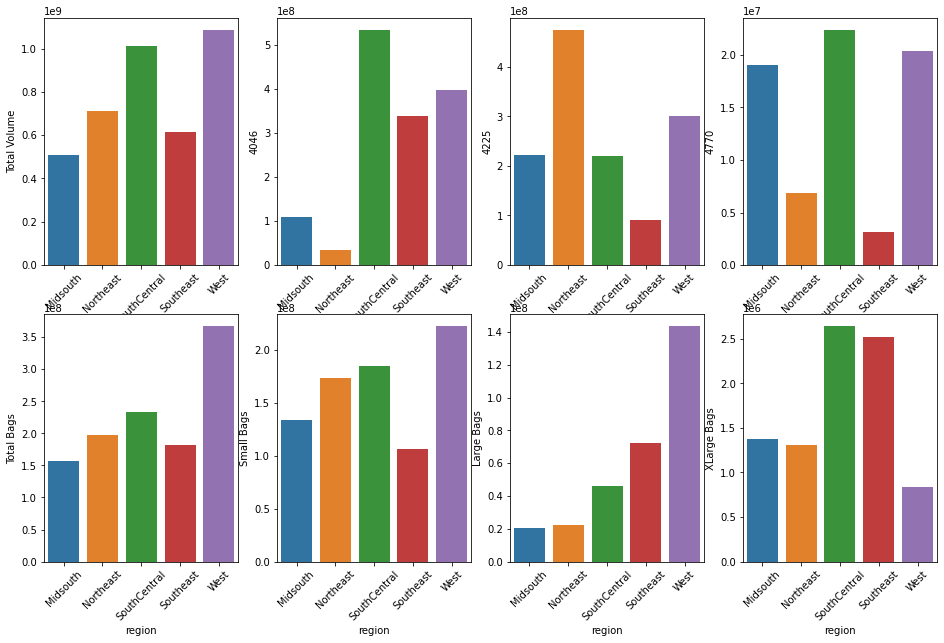

In [17]:
fig,ax=plt.subplots(nrows = 2,ncols=4,figsize=(16,10))
c = 0
r=0
for i in np.arange(1,9):
    if c<3:
        p = sns.barplot(region1["region"],region1[region1.columns[i]], ax = ax[r][c])
        for tick in p.get_xticklabels():
            tick.set_rotation(45)
        
        c+=1
    else:
        if r == 0:
            p=sns.barplot(region1["region"],region1[region1.columns[i]], ax = ax[r][c])
            for tick in p.get_xticklabels():
                tick.set_rotation(45)
            r = 1
            c=0
        elif r==1:
            p=sns.barplot(region1["region"],region1[region1.columns[i]], ax = ax[r][c])
            for tick in p.get_xticklabels():
                tick.set_rotation(45)

For total volumes, West stood out and followed by South Central. West outperforms South Central by having more volume for PLU 4225. A lot more bags were located in West than other regions, the same for small bags and large bags specifically. For X-large bags, Southern regions contain many more bags.

In [18]:
#by quarter
by_quarter = df.groupby("quarter").sum().reset_index()
by_quarter

,quarter,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
0,1,5.141012e+09,1.754567e+09,1.781253e+09,1.405034e+08,1.464677e+09,1.108495e+09,3.401889e+08,15993118.03,11106720
1,2,3.909102e+09,1.407044e+09,1.309634e+09,1.167400e+08,1.075685e+09,8.210604e+08,2.395341e+08,15090351.56,8487358
2,3,3.403557e+09,1.184995e+09,1.199368e+09,8.719973e+07,9.319793e+08,7.253599e+08,1.890115e+08,17607831.59,8491392
3,4,3.069731e+09,1.000504e+09,1.096021e+09,7.235924e+07,9.008351e+08,6.699559e+08,2.228813e+08,7997876.15,8707213


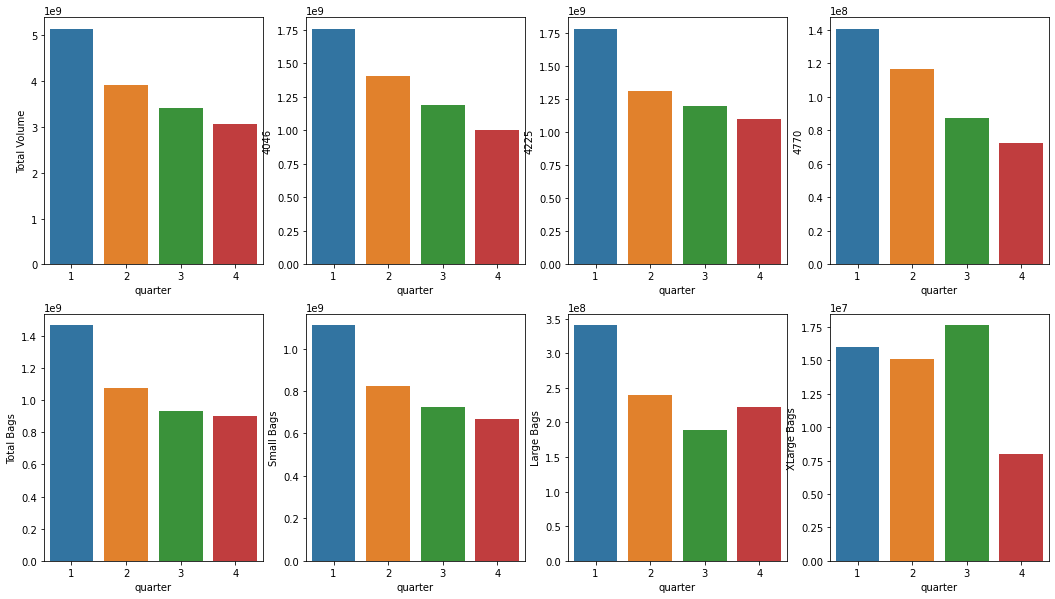

In [19]:
fig,ax=plt.subplots(nrows = 2,ncols=4,figsize=(18,10))
c = 0
r=0
for i in np.arange(1,9):
    if c<3:
        p = sns.barplot(by_quarter["quarter"],by_quarter[by_quarter.columns[i]], ax = ax[r][c])  
        c+=1
    else:
        if r == 0:
            p=sns.barplot(by_quarter["quarter"],by_quarter[by_quarter.columns[i]], ax = ax[r][c])

            r = 1
            c=0
        elif r==1:
            p=sns.barplot(by_quarter["quarter"],by_quarter[by_quarter.columns[i]], ax = ax[r][c])


Patterns are almost consistent, with quarter 1 having the most volume and number of bags.

### Explore Prices Across Different Variables

<AxesSubplot:>

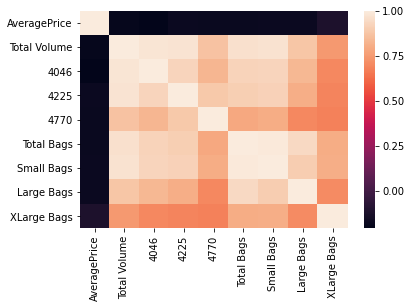

In [20]:
#correlation among numeric variables
num_df = data[['AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']]
sns.heatmap(num_df.corr())

Almost zero correlations with average price columns, and high correlations among bags and volume columns

In [21]:
#price across broad regions
data_region =  data[data["region"].apply(lambda x: x in ["Midsouth", "Northeast", "SouthCentral", "Southeast", "West"])]

<AxesSubplot:xlabel='region', ylabel='AveragePrice'>

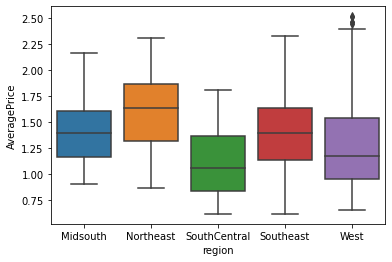

In [22]:
sns.boxplot("region","AveragePrice",data = data_region)

<AxesSubplot:xlabel='region', ylabel='Total Volume'>

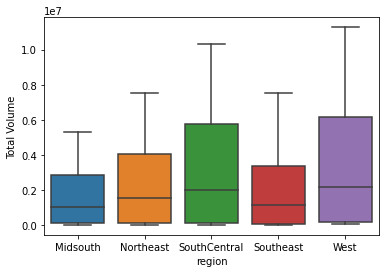

In [23]:
sns.boxplot("region","Total Volume",data = data_region)

<AxesSubplot:xlabel='region', ylabel='Total Bags'>

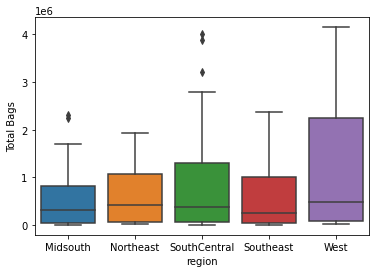

In [24]:
sns.boxplot("region","Total Bags",data = data_region)

Patterns in volume and bags across regions are very similar. For Northeast, it seems to have a higher volumne compared with its position in bags ranking, correponding to it having higher number of X-large bags compared to large and small bags.

<AxesSubplot:xlabel='month', ylabel='AveragePrice'>

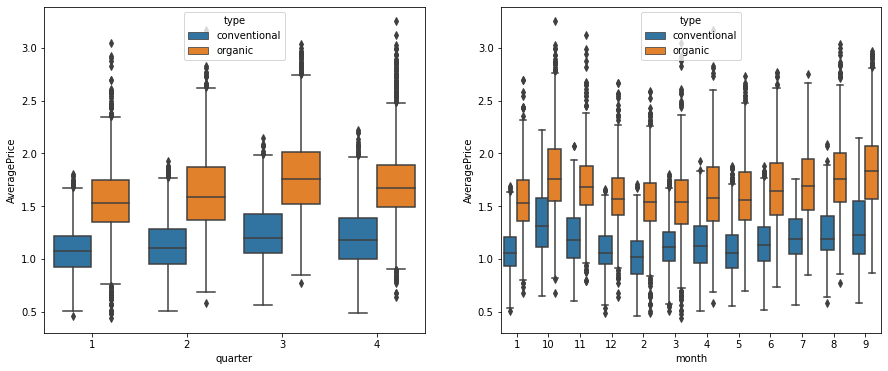

In [25]:
#price by quarters
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
sns.boxplot("quarter","AveragePrice",data = data,hue="type",ax=ax[0])
sns.boxplot("month","AveragePrice",data = data,hue="type",ax=ax[1])

We can see that average price is the highest in quarter three, lowest in quarter 1. The patterns are same for bothe organic and conventional avocados.

## Modeling
- Regression:
    - Assume time points are independent, using other independent variables
    - Use past time points as features
- Time Series:
    - SARIMA: two different models for two types
    - VAR: using all related numeric columns

In [26]:
#linear regression using other columns
from sklearn.linear_model import LinearRegression

In [27]:
#For date, lets try indicator for quarter only, use indices to model increase in time
X = pd.get_dummies(data[["ind",'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type','region','quarter']],drop_first=True)
y = data['AveragePrice']

In [28]:
#in order of time
X_train = X.iloc[:13000,:]
X_test = X.iloc[13000:,:]
y_train = data['AveragePrice'].iloc[:13000]
y_test = data['AveragePrice'].iloc[13000:]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.6000824875272541

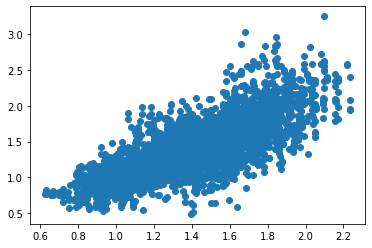

In [31]:
plt.scatter(lr.predict(X_test),y_test)

R squared is ok, but an issue here is that the split is  random, which is not a good practice for time series since order usually matters.

### ARIMA
- Since there are multiple points per date, I aggregate those rows belonging the the same type.
- It might be worth to further explore series within different regions, but for this notebook, I study the overall avergae prices.

In [62]:
conventional = data[data["type"]=="conventional"].groupby("Date")["AveragePrice"].mean()
organic = data[data["type"]=="organic"].groupby("Date")["AveragePrice"].mean()

In [63]:
conventional

Date
2015-01-04    1.009630
2015-01-11    1.111296
2015-01-18    1.133519
2015-01-25    1.115370
2015-02-01    0.962037
                ...   
2018-02-25    1.141111
2018-03-04    1.142407
2018-03-11    1.136667
2018-03-18    1.096296
2018-03-25    1.147222
Name: AveragePrice, Length: 169, dtype: float64

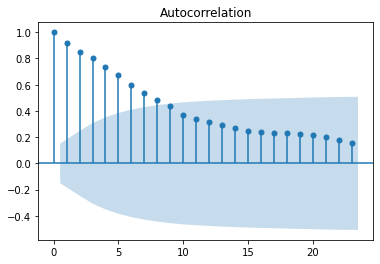

In [64]:
#check acf of prices time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
a = plot_acf(conventional)

There is an exponentially decreasing trend in acf of conventional avocado, indicating an autoregressive component in the price time series.

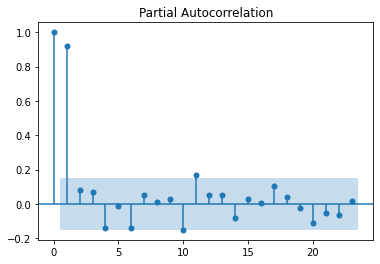

In [65]:
a = plot_pacf(conventional)

Pacf plot shows that there is an autoregressive component around three lags, there might be a seaonality as shown the small ups and downs of the plot.

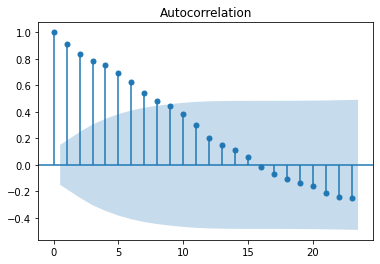

In [66]:
a = plot_acf(organic)

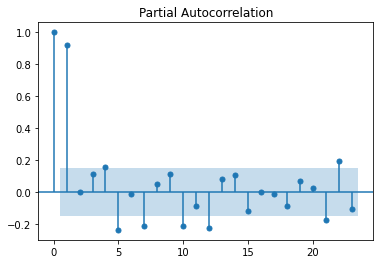

In [67]:
a = plot_pacf(organic)

There seems to be an autoregressive component with 4 lags

In [68]:
from pmdarima import auto_arima

In [69]:
auto_arima(conventional) #as reflected in the pacf plot, there is an AR(3) component

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [70]:
auto_arima(organic) #there is a MA component

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [41]:
#ARIMA model: focus on daily average since multiple rows for one day 
from statsmodels.tsa.api import ARIMA
from statsmodels.tools.eval_measures import rmse, aic

In [74]:
c_len = len(conventional)
c_train = conventional.iloc[:round(c_len *0.8)]
c_test = conventional.iloc[round(c_len *0.8):]

In [75]:
c_mod = auto_arima(conventional)

In [76]:
c_mod

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [77]:
c_preds = c_mod.predict(n_periods = len(c_test))

In [78]:
c_preds

array([1.16051496, 1.13762933, 1.15706856, 1.14284904, 1.15271687,
       1.14601316, 1.15052624, 1.1474999 , 1.14952577, 1.14817066,
       1.14907679, 1.14847097, 1.14887598, 1.14860523, 1.14878623,
       1.14866523, 1.14874611, 1.14869204, 1.14872819, 1.14870403,
       1.14872018, 1.14870938, 1.1487166 , 1.14871177, 1.148715  ,
       1.14871284, 1.14871428, 1.14871332, 1.14871397, 1.14871353,
       1.14871382, 1.14871363, 1.14871376, 1.14871367])

In [79]:
rmse(c_preds,c_test)

0.2651789835176592

In [80]:
c_data = data[data["type"]=="conventional"]

<AxesSubplot:xlabel='Date', ylabel='AveragePrice'>

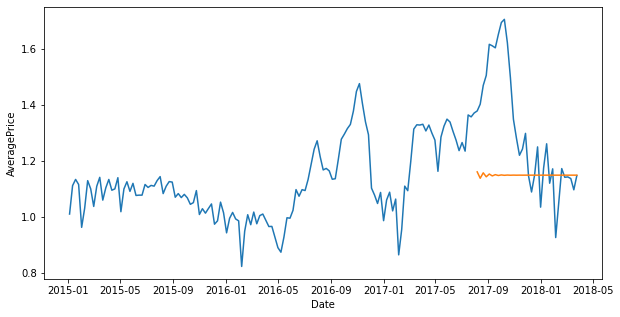

In [83]:
plt.figure(figsize=(10,5))
sns.lineplot(conventional.index,conventional)
sns.lineplot(conventional.index[round(c_len *0.8):],c_preds)

The performance of ARIMA is limited, therefore, it might be worth to explore SARIMA and include a component of seasonality.